In [1]:
import sys
sys.path.insert(1, '/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import getdist
from getdist import plots, MCSamples
import matplotlib.pyplot as plt
import numpy as np
import scipy
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
from jax.scipy.stats import uniform
import chaospy
from nfmc_jax.sinf.RQspline import kde
import torch
from scipy.special import loggamma
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

### Misc functions

In [2]:
def t2a(tens): return tens.numpy().astype(np.float64)
def a2t(arr): return torch.from_numpy(arr.astype(np.float32))
def sample_qmodel_1d(qmodel,N,Z=1,dim=0):
    samples,qvalues = qmodel.sample(N,device='cpu')
    #sample n samples
    samples = samples[:,dim]
    #use the sinf kde implementation - should use Scott's rule with no bwfactor
    kdeq = kde(samples)
    def fkde(x):
        return t2a(kdeq(a2t(x)))*Z
    return fkde,samples

def sample_gaussian(N,mean,cov,seed=seed):
    g1 = n_mvn.rvs(mean=mean,cov=cov,size=N,random_state=seed)
    return np.atleast_2d(g1)

def double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2,seed=seed):
    g1 = n_mvn.rvs(mean=mean1,cov=cov1,size=int(N*w1),random_state=seed)
    g2 = n_mvn.rvs(mean=mean2,cov=cov2,size=int(N*(1-w1)),random_state=seed)
    return np.concatenate([np.atleast_2d(g1),np.atleast_2d(g2)])

def sample_truth_1d(N,mean,cov,dim=0):
    mean,cov = np.asarray(mean),np.asarray(cov)
    samples = sample_gaussian(N,mean,cov)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def double_sample_truth_1d(N,w1,mean1,mean2,cov1,cov2,dim=0):
    mean1,mean2,cov1,cov2 = np.asarray(mean1),np.asarray(mean2),np.asarray(cov1),np.asarray(cov2)
    samples = double_sample_gaussian(N,w1,mean1,mean2,cov1,cov2)
    samples = samples[:,dim]
    kdeq = kde(a2t(samples))
    def fkde(x):
        return t2a(kdeq(a2t(x)))
    return fkde,samples

def log_1d_normal(x,mu=0,sigma=1,n=1):
    return -1/2*( n*np.log(2*np.pi) + sigma + ((x-mu)/sigma)**2 )

def plot_1d_uncorrelated(trace,low,high,n,n_1d=1000,beta_idx=None,sig_scale=1/10):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    mu_truth,sigma_truth = jnp.zeros(n),sig_scale*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(sample_truth_1d(n_1d,mu_truth,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1) # just to suppress noise in kde since all the same in uncorrelated...
#     plt.plot(samples[0]['q{0}'.format(beta_idx)],np.exp(logp[0]['q{0}'.format(beta_idx)]),ls=' ',marker='.')
    plt.axvline(0,ls='--',c='k')
    plt.show()
    return 0

def plot_1d_double(trace,low,high,n,n_1d=1000,beta_idx=None,w1=0.3,mu1_diag=0.625, mu2_diag=-0.325,sig_scale=1/10,sig_scale_12=1/2):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    sigma_truth = sig_scale*jnp.ones(n)
    mu1_truth,mu2_truth = mu1_diag*jnp.ones(n),mu2_diag*jnp.ones(n)
    x1_1d = np.linspace(low,high,n_1d)
    if(beta_idx is None): beta_idx=qnums.max()
    truths=[]
    logZpq = trace['logZ'][0]['q{0}_pq_w'.format(beta_idx)]
    for d in range(n):
        plt.plot(x1_1d,
                       sample_qmodel_1d(qmodels[0]['q{0}_w'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
                       ls='-',marker=' ',lw=1,
                       c='C{0}'.format(d),
                      )
        plt.plot(x1_1d,
               sample_qmodel_1d(qmodels[0]['q{0}_uw'.format(beta_idx)],n_1d,Z=1,dim=d)[0](x1_1d),
               ls=':',marker=' ',lw=1,
               c='C{0}'.format(d),
              )
        truths.append(double_sample_truth_1d(n_1d,w1,mu1_truth,mu2_truth,sigma_truth*sig_scale_12,sigma_truth,dim=d)[0](x1_1d))
   
    plt.plot(x1_1d,np.mean(np.array(truths),axis=0),c='k',zorder=-1)
    plt.axvline(mu1_diag,ls='--',c='k')
    plt.axvline(mu2_diag,ls='--',c='k')
    plt.show()
    return 0



In [9]:
#a place to put the common settings to declutter the below but still be transparent
def run_nfo(log_like,log_prior,
    n, #number of sobol points
    low=-1.,
    high=1.,
    knots=None,
    knots_trainable=5,
    bw=1.,
    rel_bw=1,
    layers=5,
    ktrunc=jnp.inf,
    t_ess=0.7,
    beta_max=1.,
    rel_beta=0.5,
    frac_rel_beta_AF = 1,
    alpha_w = (0,0),
    alpha_uw = (0,0),
    latent_sigma=2.4/(2**2),  #FIXME put this in the code as default
    use_latent_beta2=False,
    use_pq_beta_IW1=False, 
    top_verbose=True,
    verbose=False,
    trainable_qw=True,
    sgd_steps=10):
    
    n_prior = 10*n
    n0=n_prior
    N=n_prior
    aN=int(2*N)
    bN=n
    cN=n
    dN=n
    if(n<6):
        latent_sigma=1
    else:
        latent_sigma*=((n)**(-1/2))
    dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
    bounds=np.array([low*np.ones(n),high*np.ones(n)])
    init_prior=dist1d
    init_prior = np.atleast_2d(dist1d.sample(n_prior+1,rule='sobol')).T[1:] #drop first (0,0) sample because cheating
    trace = nfmc_jax.infer_nfomc(log_like, log_prior, jnp.array(init_prior), 
                             log_prior_args=((jnp.array([low]), jnp.array([high]))), 
                             inference_mode="optimization", 
                              vmap=True, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_latent=cN,
                               expl_top_qw=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=1, 
                               N_temp=int(12*n),
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=verbose,
                               top_verbose=top_verbose,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               knots_trainable=knots_trainable,
                               random_seed=seed
                             )
    
    return trace

# Uncorrelated Gaussian

### 10 dims

In [10]:
n=10
def log_like_ucg(x,mu_diag=0,sig_scale=1/10):
    n=x.shape[-1]
    mu,sigma = mu_diag*jnp.ones(n),sig_scale*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * jnp.prod(sigma** 2) ) - 0.5 * jnp.dot((x - mu)**2 , (1/ (2 * sigma ** 2)))

def log_flat_prior(x,low,high):
    n=x.shape[-1]
    return -n*jnp.log((high-low))#uniform.logpdf(x,loc=0,scale=2)

In [11]:
warnings.filterwarnings('default') #ignore overflow warnings
ug10 = run_nfo(n=n,log_like=log_like_ucg,log_prior=log_flat_prior,top_verbose=True,
                  low=-1.,high=1.,beta_max=1.5
                 )

Inference mode is optimization. Maximum beta is: 1.5
stage:  0
stage:  1
After first quw fit, beta=0.00
beta=0.0029
stage:  2
After first quw fit, beta=0.00
beta=0.0029
stage:  3
After first quw fit, beta=0.00
using beta2=0.00 at idx 1, at stage-1 = 2
finished with latent draw, took 0 tries
beta=0.0029
stage:  4
After first quw fit, beta=0.00
using beta2=0.00 at idx 1, at stage-1 = 3
finished with latent draw, took 0 tries
beta=0.0029
stage:  5
After first quw fit, beta=0.00
using beta2=0.00 at idx 1, at stage-1 = 4
finished with latent draw, took 0 tries
beta=0.0029
stage:  6
After first quw fit, beta=0.00
using beta2=0.00 at idx 4, at stage-1 = 5
finished with latent draw, took 0 tries
beta=0.0246
stage:  7
After first quw fit, beta=0.04
using beta2=0.00 at idx 5, at stage-1 = 6
finished with latent draw, took 0 tries
beta=0.0331
stage:  8
After first quw fit, beta=0.05
using beta2=0.02 at idx 6, at stage-1 = 7
finished with latent draw, took 0 tries
beta=0.0348
stage:  9
After first

/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.13 at idx 16, at stage-1 = 19
finished with latent draw, took 0 tries
beta=0.2450
stage:  21
After first quw fit, beta=0.37
using beta2=0.13 at idx 16, at stage-1 = 20
finished with latent draw, took 0 tries
beta=0.2742
stage:  22
After first quw fit, beta=0.41


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.16 at idx 17, at stage-1 = 21
finished with latent draw, took 0 tries
beta=0.3062
stage:  23
After first quw fit, beta=0.46


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.19 at idx 19, at stage-1 = 22
finished with latent draw, took 0 tries
beta=0.3724
stage:  24
After first quw fit, beta=0.56


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.19 at idx 19, at stage-1 = 23
finished with latent draw, took 0 tries
beta=0.4328
stage:  25
After first quw fit, beta=0.65


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.25 at idx 20, at stage-1 = 24
finished with latent draw, took 0 tries
beta=0.4756
stage:  26
After first quw fit, beta=0.71


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.27 at idx 21, at stage-1 = 25
finished with latent draw, took 0 tries
beta=0.5322
stage:  27
After first quw fit, beta=0.80


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.31 at idx 22, at stage-1 = 26
finished with latent draw, took 0 tries
beta=0.6354
stage:  28
After first quw fit, beta=0.95


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.43 at idx 24, at stage-1 = 27
finished with latent draw, took 0 tries
beta=0.8220
stage:  29
After first quw fit, beta=1.23


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.48 at idx 25, at stage-1 = 28
finished with latent draw, took 0 tries
beta=1.0000
Finished NFO ...


/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


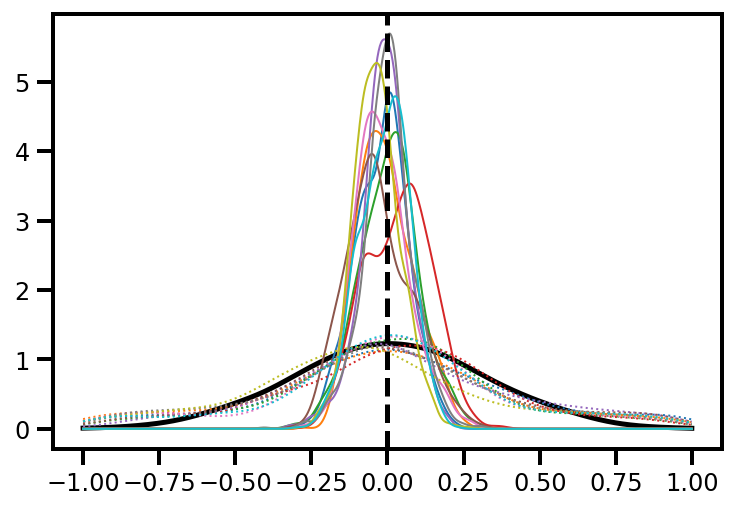

In [12]:
a = plot_1d_uncorrelated(ug10,-1,1,n)#,beta_idx=19) #By default these plots show the final beta

## 18 dims

In [13]:
n=18

/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
warnings.filterwarnings('ignore') #ignore overflow warnings
ug18 = run_nfo(n=n,log_like=log_like_ucg,log_prior=log_flat_prior,top_verbose=False,
               beta_max=1.5 )

Inference mode is optimization. Maximum beta is: 1.5


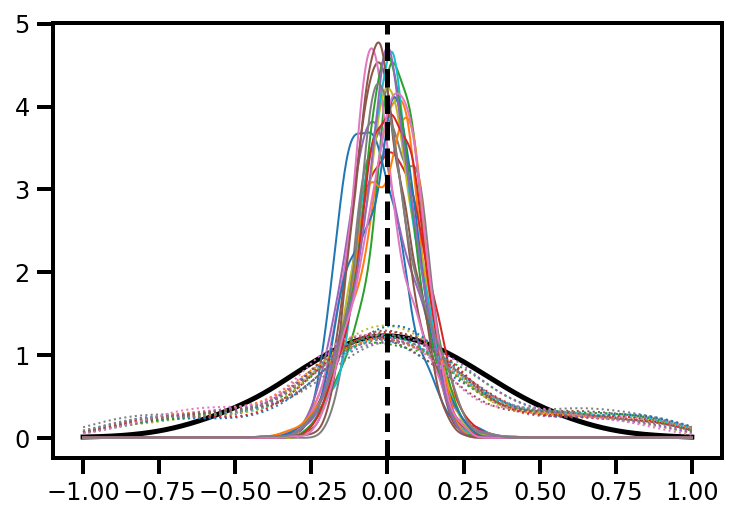

0

In [15]:
plot_1d_uncorrelated(ug18,-1.,1.,n)

# Double Gaussian test

## 3 dims
Notes:
- Also while we recover the second peak for $d=2,3$, we lose it in $d=4,5,10$ with current settings. 
- In $d=3$ we lose it if we set $\beta_{\rm{max}}$ to 1 (no problems with 1.5).

In [16]:
n=3
def log_like_ducg(x ,w1=0.3,mu1=0.625 ,mu2=-0.325 ,sig_scale=1/10,sig_scale_12=1/2):
    n=x.shape[-1]
    w2=1-w1
    log_like1 = log_like_ucg(x,mu_diag=mu1,sig_scale=sig_scale*sig_scale_12) #make first narrower like before
    log_like2 = log_like_ucg(x,mu_diag=mu2,sig_scale=sig_scale)
    return  logsumexp(jnp.array([jnp.log(w1) + log_like1, jnp.log(w2) + log_like2]), axis=0)

In [17]:
warnings.filterwarnings('ignore') #ignore overflow warnings
dug3 = run_nfo(n=n,log_like=log_like_ducg,log_prior=log_flat_prior,top_verbose=False,
                beta_max=1.5,
                  low=-1.,high=1.
                 )

Inference mode is optimization. Maximum beta is: 1.5


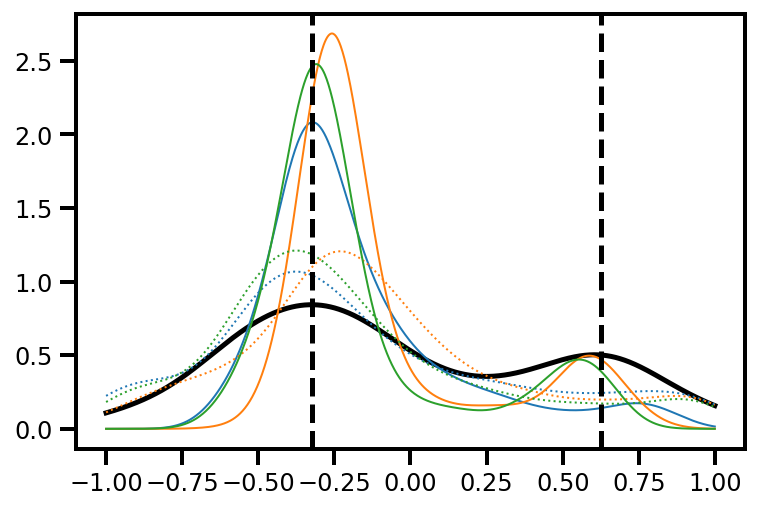

0

In [18]:
plot_1d_double(dug3,-1.,1.,n) #at lower beta this gets both peaks

## 10 dims


In [19]:
n=10
warnings.filterwarnings('default') #ignore overflow warnings
dug10 = run_nfo(n=n,log_like=log_like_ducg,log_prior=log_flat_prior,top_verbose=False,
                beta_max=1.5,
                  low=-1.,high=1.
                 )

Inference mode is optimization. Maximum beta is: 1.5


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encou

/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


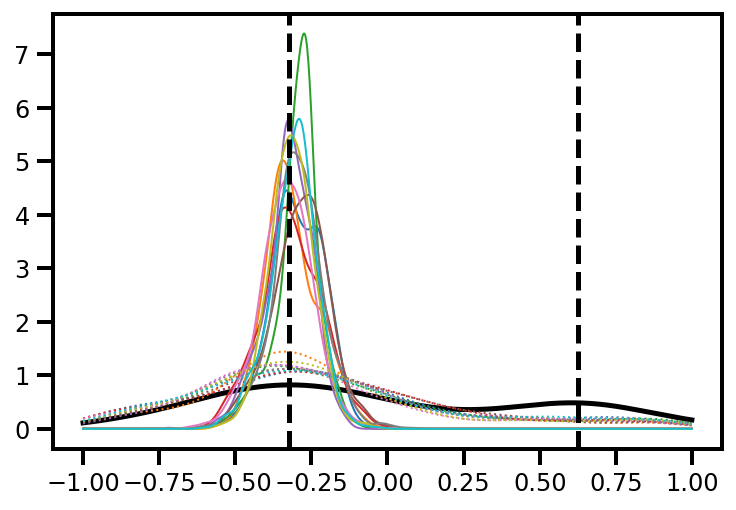

0

In [20]:
plot_1d_double(dug10,-1.,1.,n) #no second peak here...

# Correlated Gaussian test

## 5 dims

In [50]:
n = 5
# wishart draw from Richard's example
# lazily force this to give a certain condition number and choose scale by eye for some level of control...
def get_icov(n,target=200,iseed=seed,eps=1,scale=50):
    condition=0
    eigmax=np.inf
    this_seed=iseed
    while(abs(condition-target)>eps):
        wish = scipy.stats.wishart(df=n, scale=np.eye(n)* scale,seed=this_seed)
        iC = wish.rvs(size=1)
        C = np.linalg.inv(iC)
        eigs = np.linalg.eigvals(C)
        eigmax,eigmin = eigs.max(),eigs.min()
        condition = eigmax/eigmin
        this_seed+=1
    print("PSD: ",np.all(eigs>0))
    print("Condition number: ", condition)
    print("Op norm: ", eigmax)
    return iC,C

iCov,Cov=get_icov(n,eps=1)
def log_like_cg(x,mu_diag=0,icov=iCov):
    n=x.shape[-1]
    mu = mu_diag*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * 1/jnp.linalg.det(icov) ) - 0.5 * jnp.dot((x - mu),jnp.dot(icov,(x - mu)))


PSD:  True
Condition number:  199.54502688948327
Op norm:  0.33203908121598824


/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
cg5 = run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=True,
                  beta_max=1.5,
                  low=-1.,high=1.,
                 )

Inference mode is optimization. Maximum beta is: 1.5
stage:  0
stage:  1
After first quw fit, beta=0.00
beta=0.0024
stage:  2
After first quw fit, beta=0.00
beta=0.0027
stage:  3
After first quw fit, beta=0.00
using beta2=0.00 at idx 1, at stage-1 = 2
finished with latent draw, took 0 tries
beta=0.0027
stage:  4
After first quw fit, beta=0.00
using beta2=0.00 at idx 2, at stage-1 = 3
finished with latent draw, took 0 tries
beta=0.0056
stage:  5
After first quw fit, beta=0.01
using beta2=0.00 at idx 3, at stage-1 = 4
finished with latent draw, took 0 tries
beta=0.0090
stage:  6
After first quw fit, beta=0.01
using beta2=0.01 at idx 4, at stage-1 = 5
finished with latent draw, took 0 tries
beta=0.0115
stage:  7
After first quw fit, beta=0.02
using beta2=0.01 at idx 5, at stage-1 = 6
finished with latent draw, took 0 tries
beta=0.0163
stage:  8
After first quw fit, beta=0.02
using beta2=0.01 at idx 6, at stage-1 = 7
finished with latent draw, took 0 tries
beta=0.0216
stage:  9
After first

/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.04 at idx 12, at stage-1 = 15
finished with latent draw, took 1 tries
beta=0.0968
stage:  17
After first quw fit, beta=0.15
using beta2=0.04 at idx 12, at stage-1 = 16
finished with latent draw, took 2 tries
beta=0.0968
stage:  18
After first quw fit, beta=0.15


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.07 at idx 15, at stage-1 = 17
finished with latent draw, took 1 tries
beta=0.1563
stage:  19
After first quw fit, beta=0.23


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.10 at idx 17, at stage-1 = 18
finished with latent draw, took 1 tries
beta=0.1995
stage:  20
After first quw fit, beta=0.30


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.10 at idx 17, at stage-1 = 19
finished with latent draw, took 0 tries
beta=0.2277
stage:  21
After first quw fit, beta=0.34


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.16 at idx 18, at stage-1 = 20
finished with latent draw, took 0 tries
beta=0.2692
stage:  22
After first quw fit, beta=0.40


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.23 at idx 20, at stage-1 = 21
finished with latent draw, took 8 tries
beta=0.4450
stage:  23
After first quw fit, beta=0.67


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.27 at idx 21, at stage-1 = 22
finished with latent draw, took 0 tries
beta=0.7365
stage:  24
After first quw fit, beta=1.10


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.44 at idx 22, at stage-1 = 23
finished with latent draw, took 0 tries
beta=0.9340
stage:  25
After first quw fit, beta=1.40


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


using beta2=0.44 at idx 22, at stage-1 = 24
finished with latent draw, took 0 tries
beta=1.0000
Finished NFO ...


Migrate to getdist for corner-style plots quickly - we sacrifice the ability to see the details such as AF, latent draw, gradient etc, but these lose meaning in high-$d$ anyways

In [23]:
def plot_corr_gd(trace,Cov,Ngd=1000,beta_idx=None):
    qmodels=trace['q_models']
    logp=trace['logp']
    samples=trace['q_samples']
    qnums = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(trace['q_models'][0].keys())])
    names = ["x%s"%i for i in range(n)]
    labels =  ["x_%s"%i for i in range(n)]

    truth = n_mvn.rvs(mean=np.zeros(n),cov=Cov,size=Ngd)
    truth_gd = MCSamples(samples=truth,names = names, labels = labels, label='truth')

    if(beta_idx is None): beta_idx=qnums.max()
    s_w,s_uw = t2a(qmodels[0]['q{0}_w'.format(beta_idx)].sample(Ngd,device='cpu')[0]),t2a(qmodels[0]['q{0}_uw'.format(beta_idx)].sample(Ngd,device='cpu')[0])
    samples_w = MCSamples(samples=s_w,names = names, labels = labels, label='q_w')
    samples_uw = MCSamples(samples=s_uw,names = names, labels = labels, label='q_uw')

    # Triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_uw,truth_gd,samples_w], filled=True)
    plt.show()

/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Removed no burn in
Removed no burn in
Removed no burn in


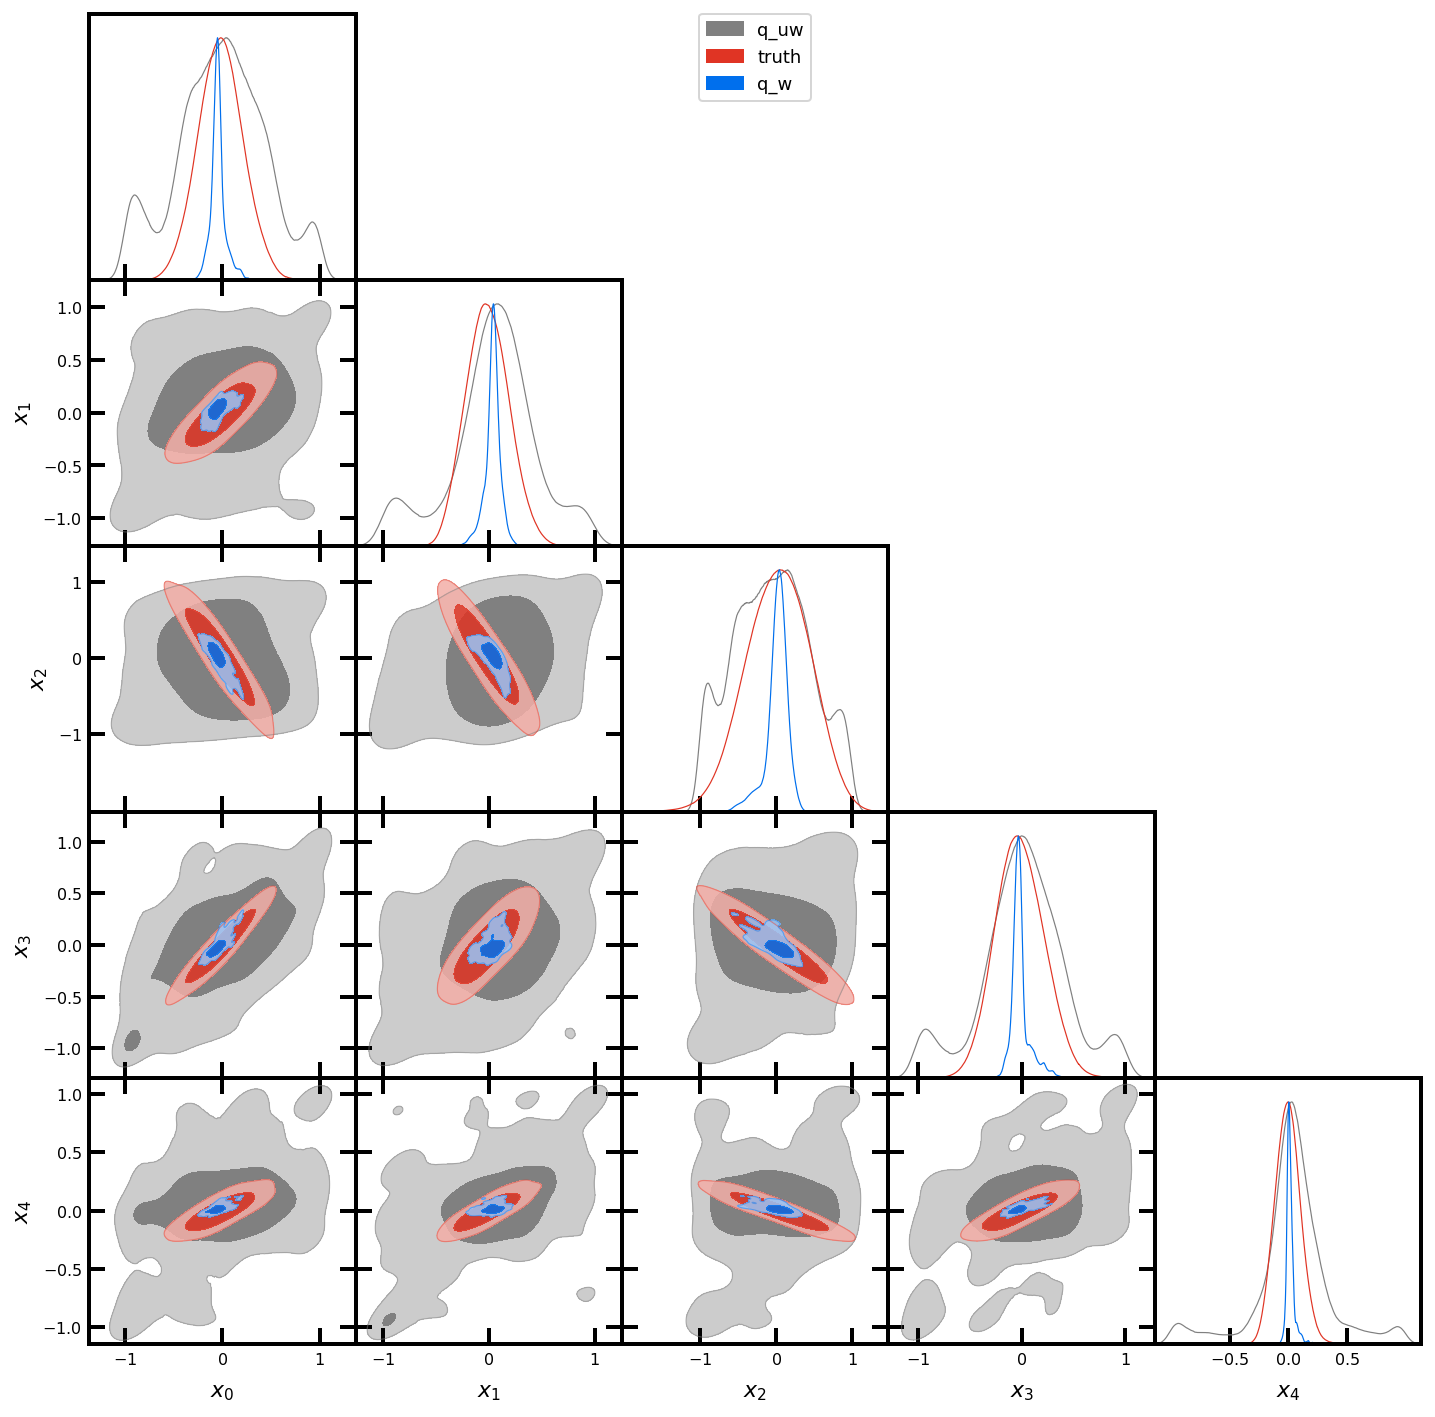

In [24]:
plot_corr_gd(cg5,Cov)

$\beta=1$

/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


beta=1.105 at level 23 out of 26 levels
Removed no burn in
Removed no burn in
Removed no burn in


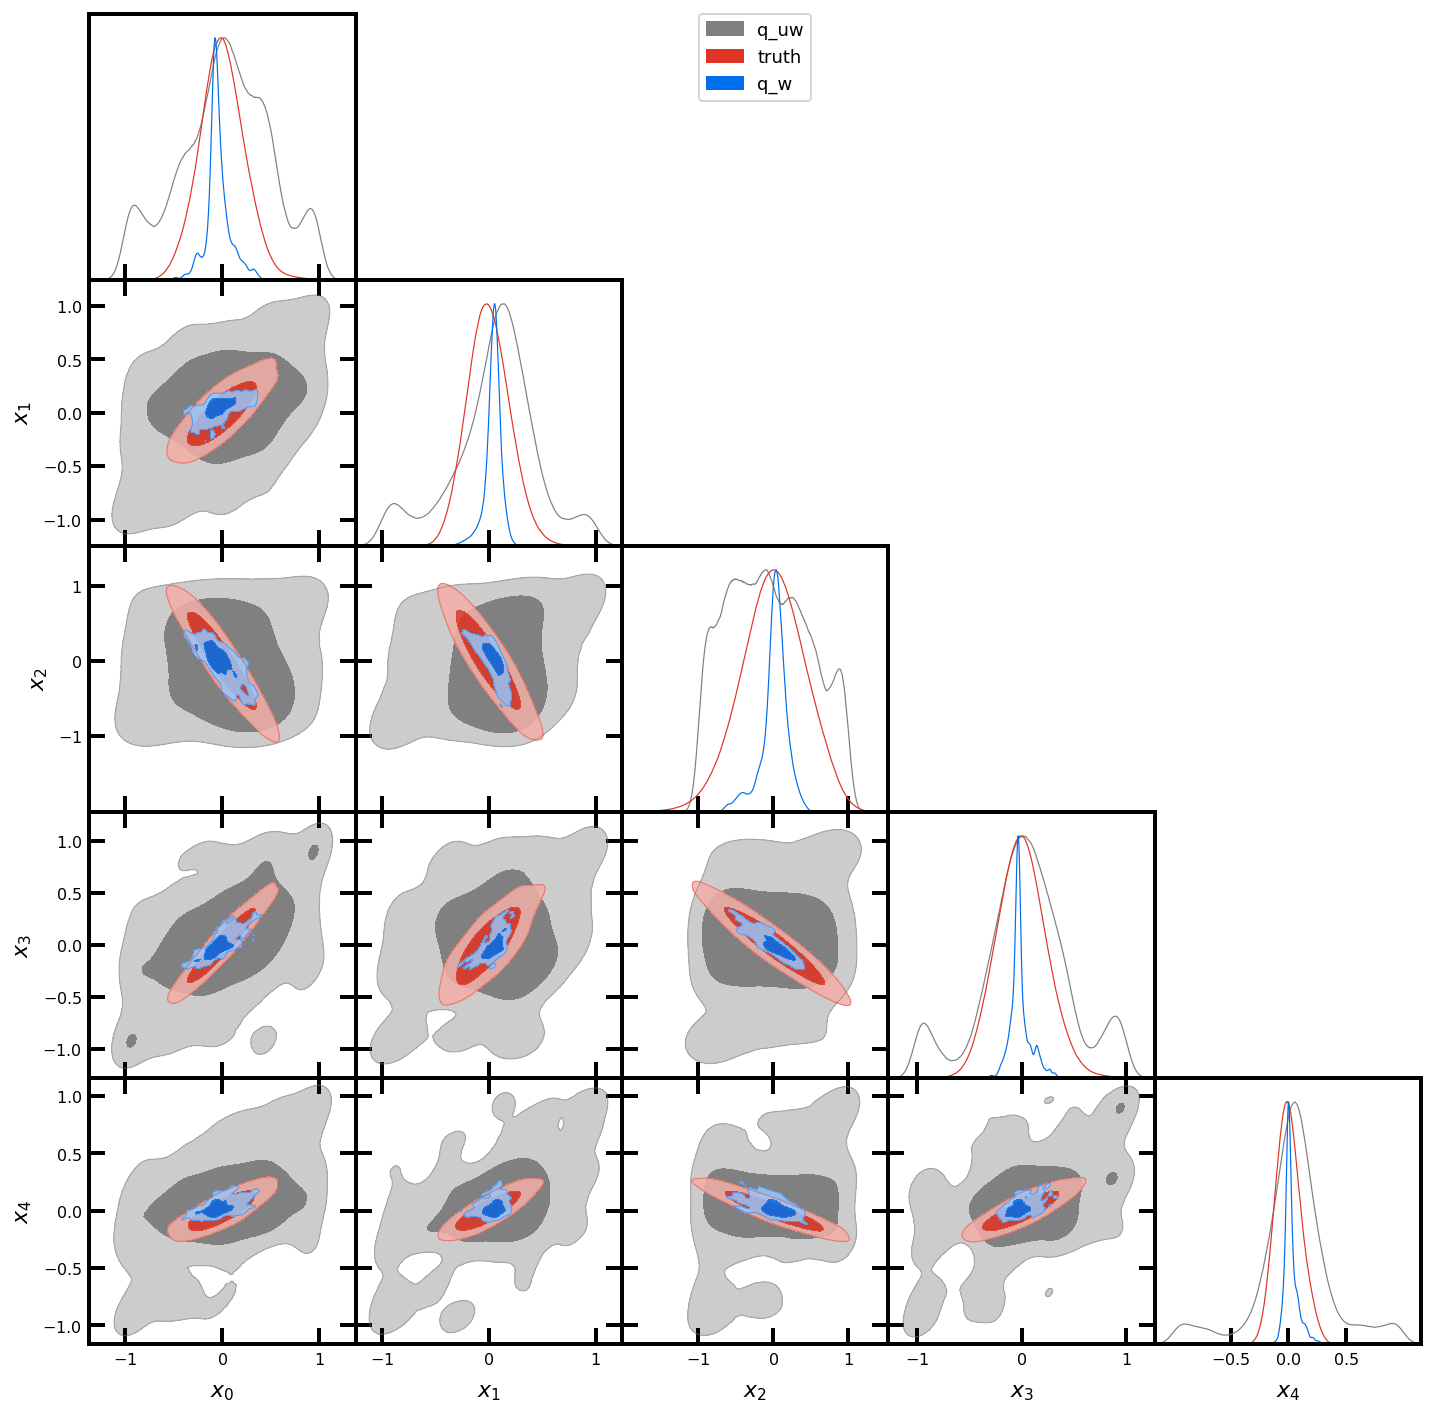

In [25]:
beta1idx=np.argmin(np.abs(np.array(cg5['betas'][0])*1.5-1))
print('beta={0:.3f} at level {1} out of {2} levels'.format(cg5['betas'][0][beta1idx]*1.5,beta1idx,len(cg5['betas'][0])))
plot_corr_gd(cg5,Cov,beta_idx=beta1idx)

## 10 dims

In [26]:
n = 10
iCov,Cov=get_icov(n,eps=1,scale=25)
def log_like_cg(x,mu_diag=0,icov=iCov):
    n=x.shape[-1]
    mu = mu_diag*jnp.ones(n)
    return -0.5 * jnp.log(2 * jnp.pi * 1/jnp.linalg.det(icov) ) - 0.5 * jnp.dot((x - mu),jnp.dot(icov,(x - mu)))

/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PSD:  True
Condition number:  199.08320751596926
Op norm:  0.3175848066033764


In [27]:
cg10 = run_nfo(n=n,log_like=log_like_cg,log_prior=log_flat_prior,top_verbose=False,
                  beta_max=1.5,rel_beta=.75,
                  use_latent_beta2=True, #this helps some in terms of fewer beta compared to drawing from q_w
                  low=-1.,high=1.,
                  #many beta steps~100
                 )

Inference mode is optimization. Maximum beta is: 1.5


/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encou

/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))
/Users/jsull/Documents/berkeley/stats/jax/NFMC_Jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encou

Removed no burn in
Removed no burn in
Removed no burn in


/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


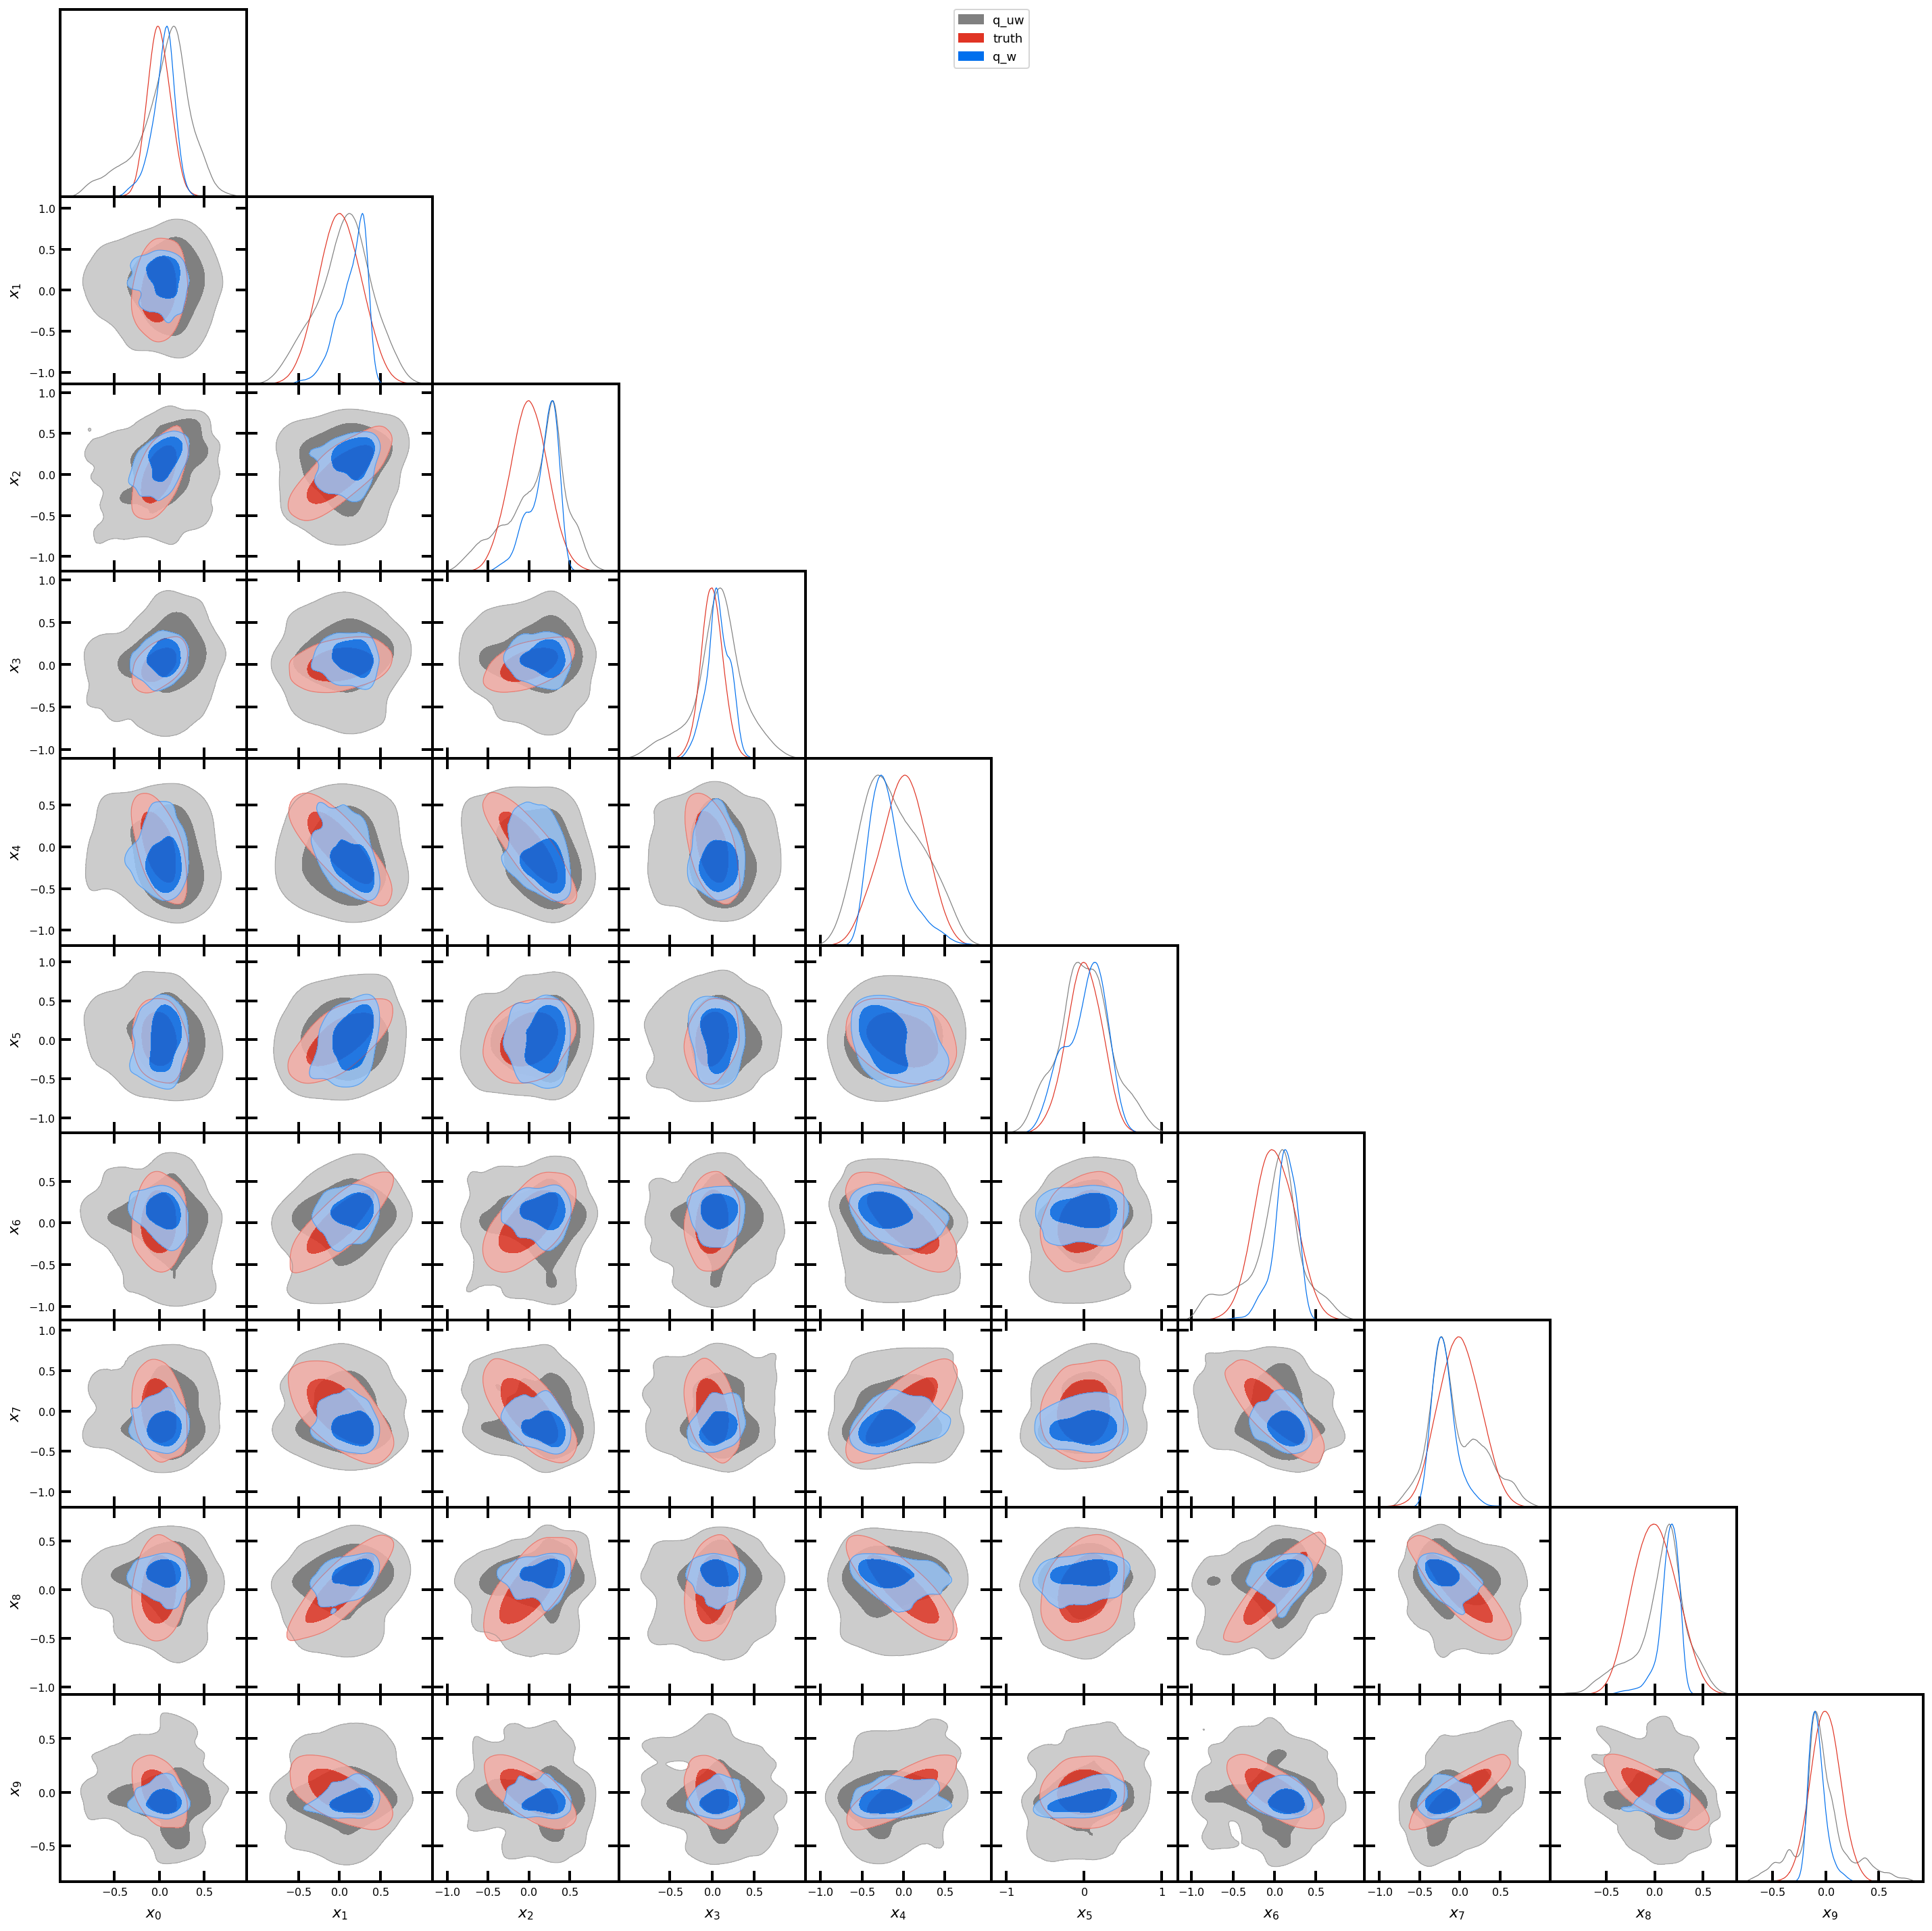

In [28]:
plot_corr_gd(cg10,Cov)

At $\beta=1$

In [29]:
beta1idx=np.argmin(np.abs(np.array(cg10['betas'][0])*1.5-1))
print('beta={0:.3f} at level {1} out of {2} levels'.format(cg10['betas'][0][beta1idx]*1.5,beta1idx,len(cg10['betas'][0])))

beta=0.976 at level 120 out of 121 levels


/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Removed no burn in
Removed no burn in
Removed no burn in


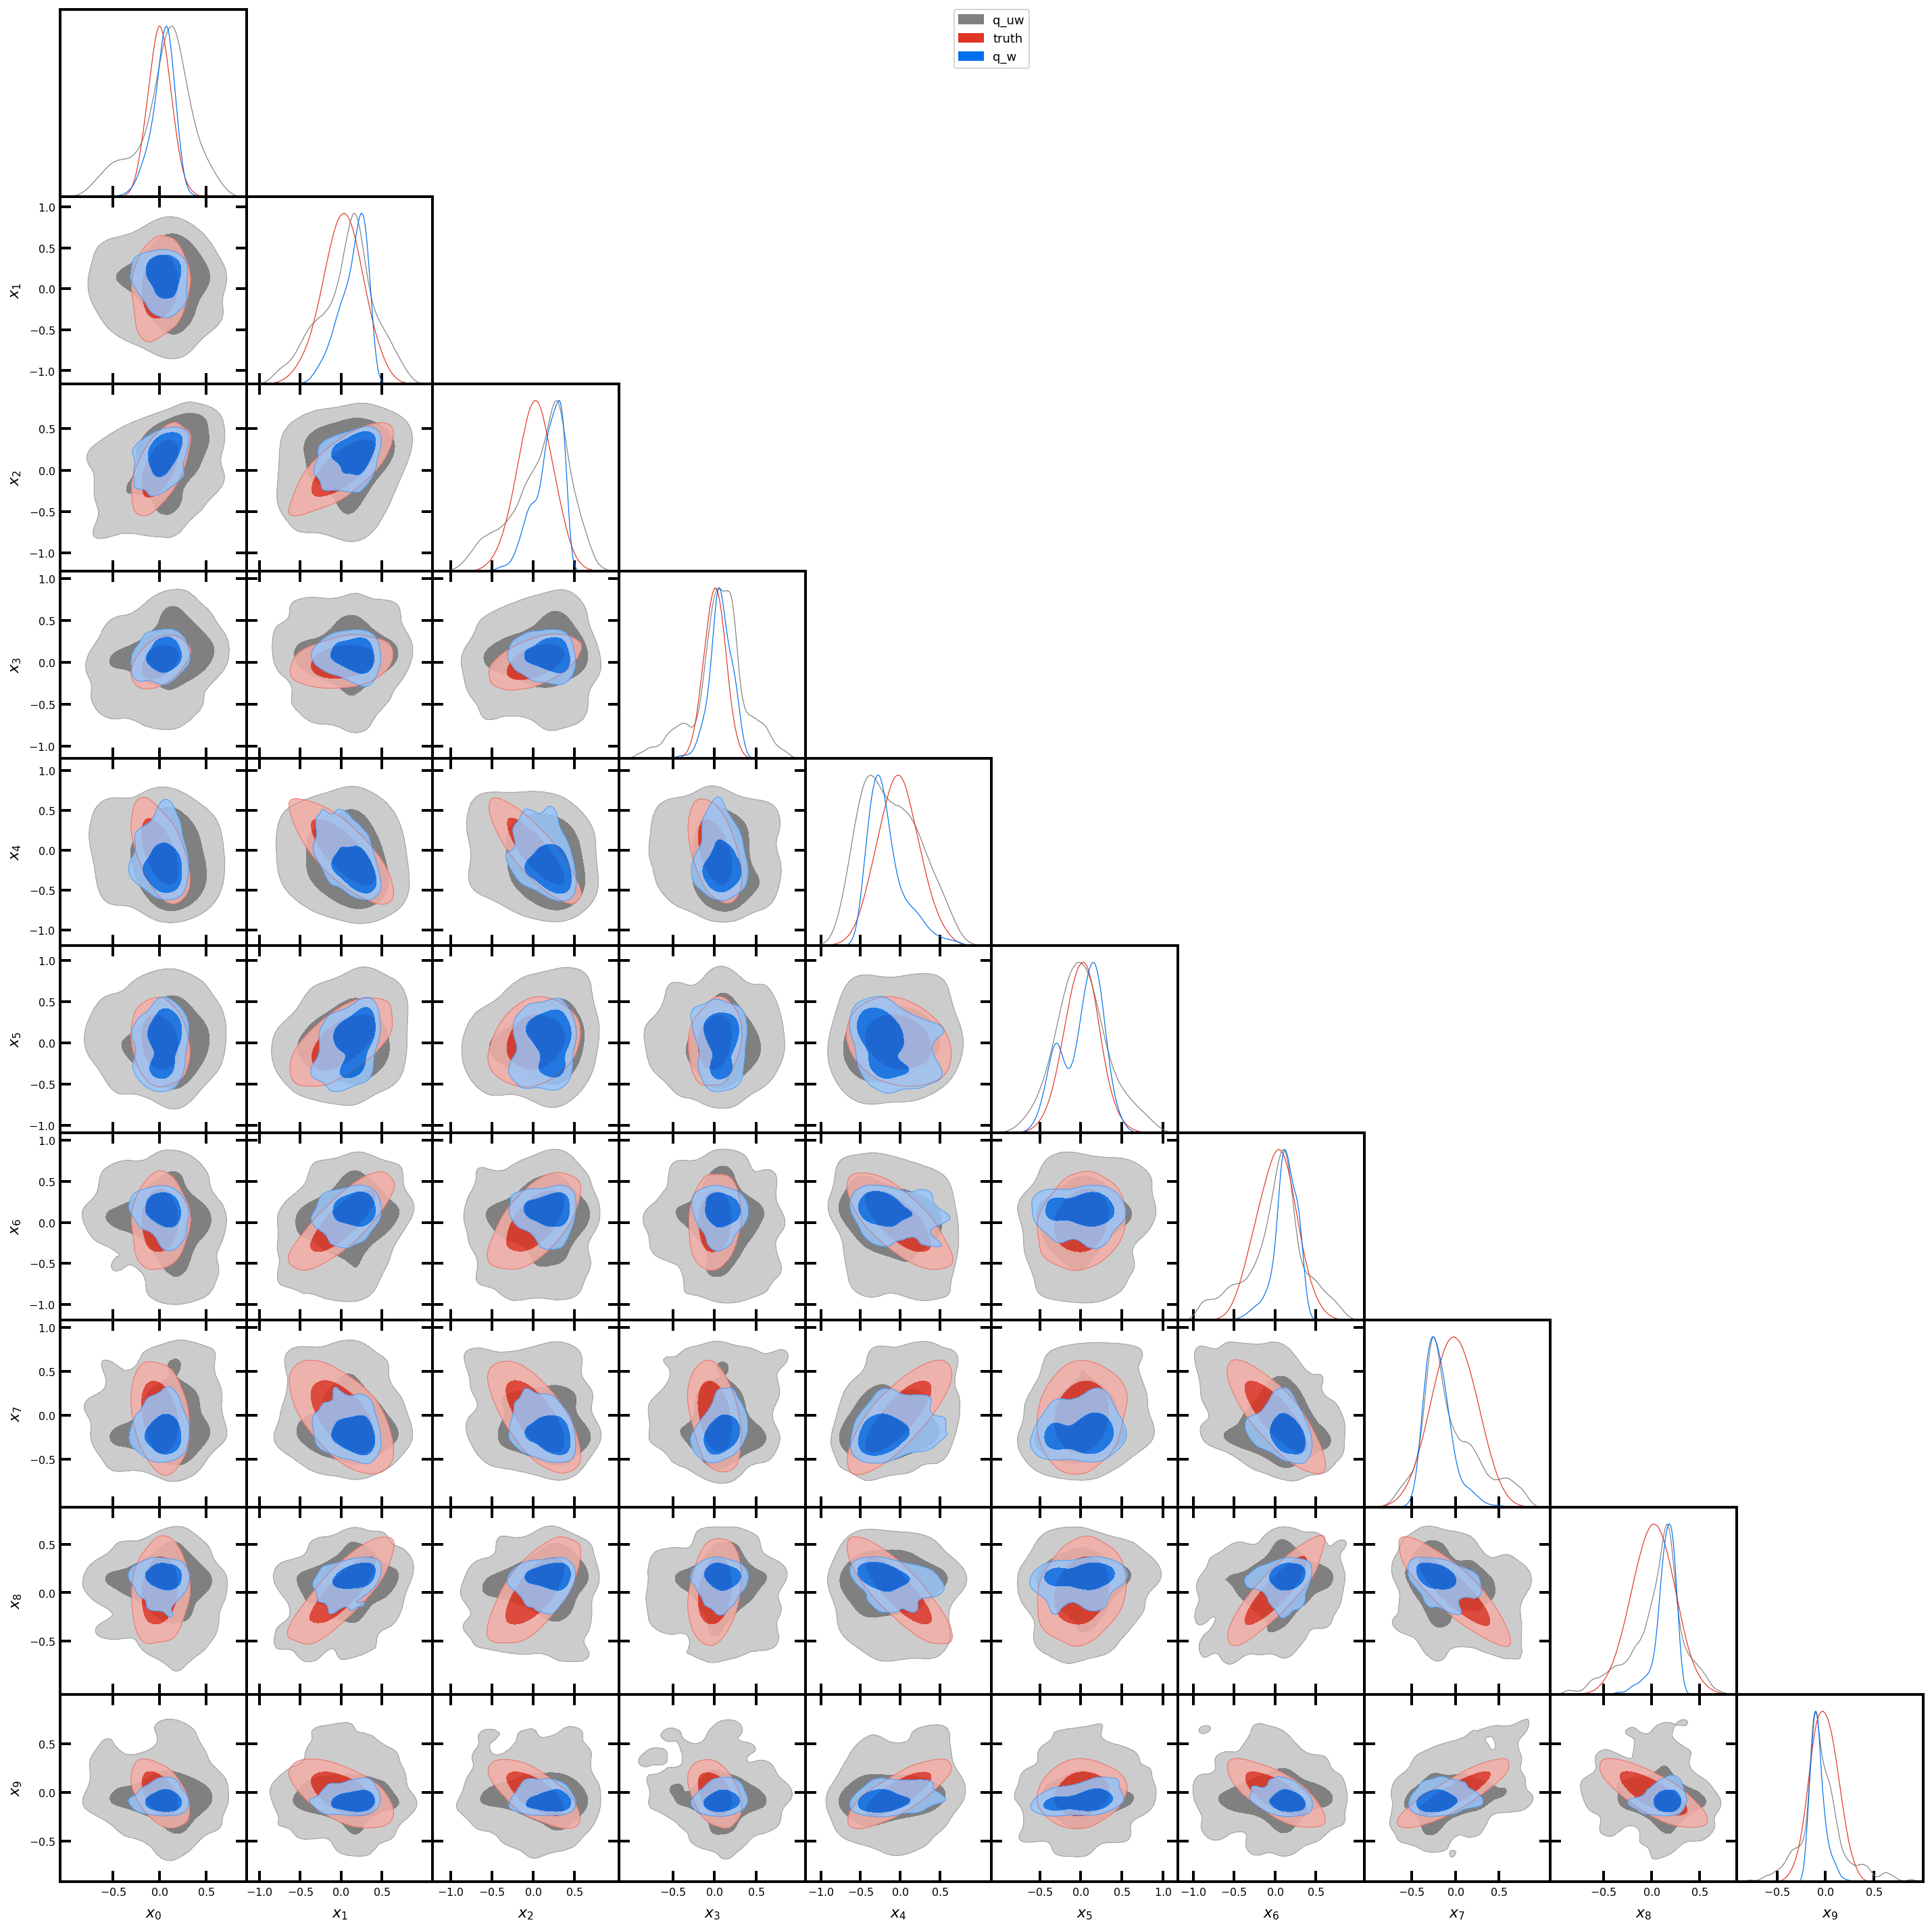

In [30]:
plot_corr_gd(cg10,Cov,beta_idx=beta1idx)

## Test p/q_uw weighting samples

/Users/jsull/anaconda3/envs/pymc3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-52-1ab57b01882c>:13: RuntimeWarning: overflow encountered in exp
  IW1=np.exp(logIW1)


25
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


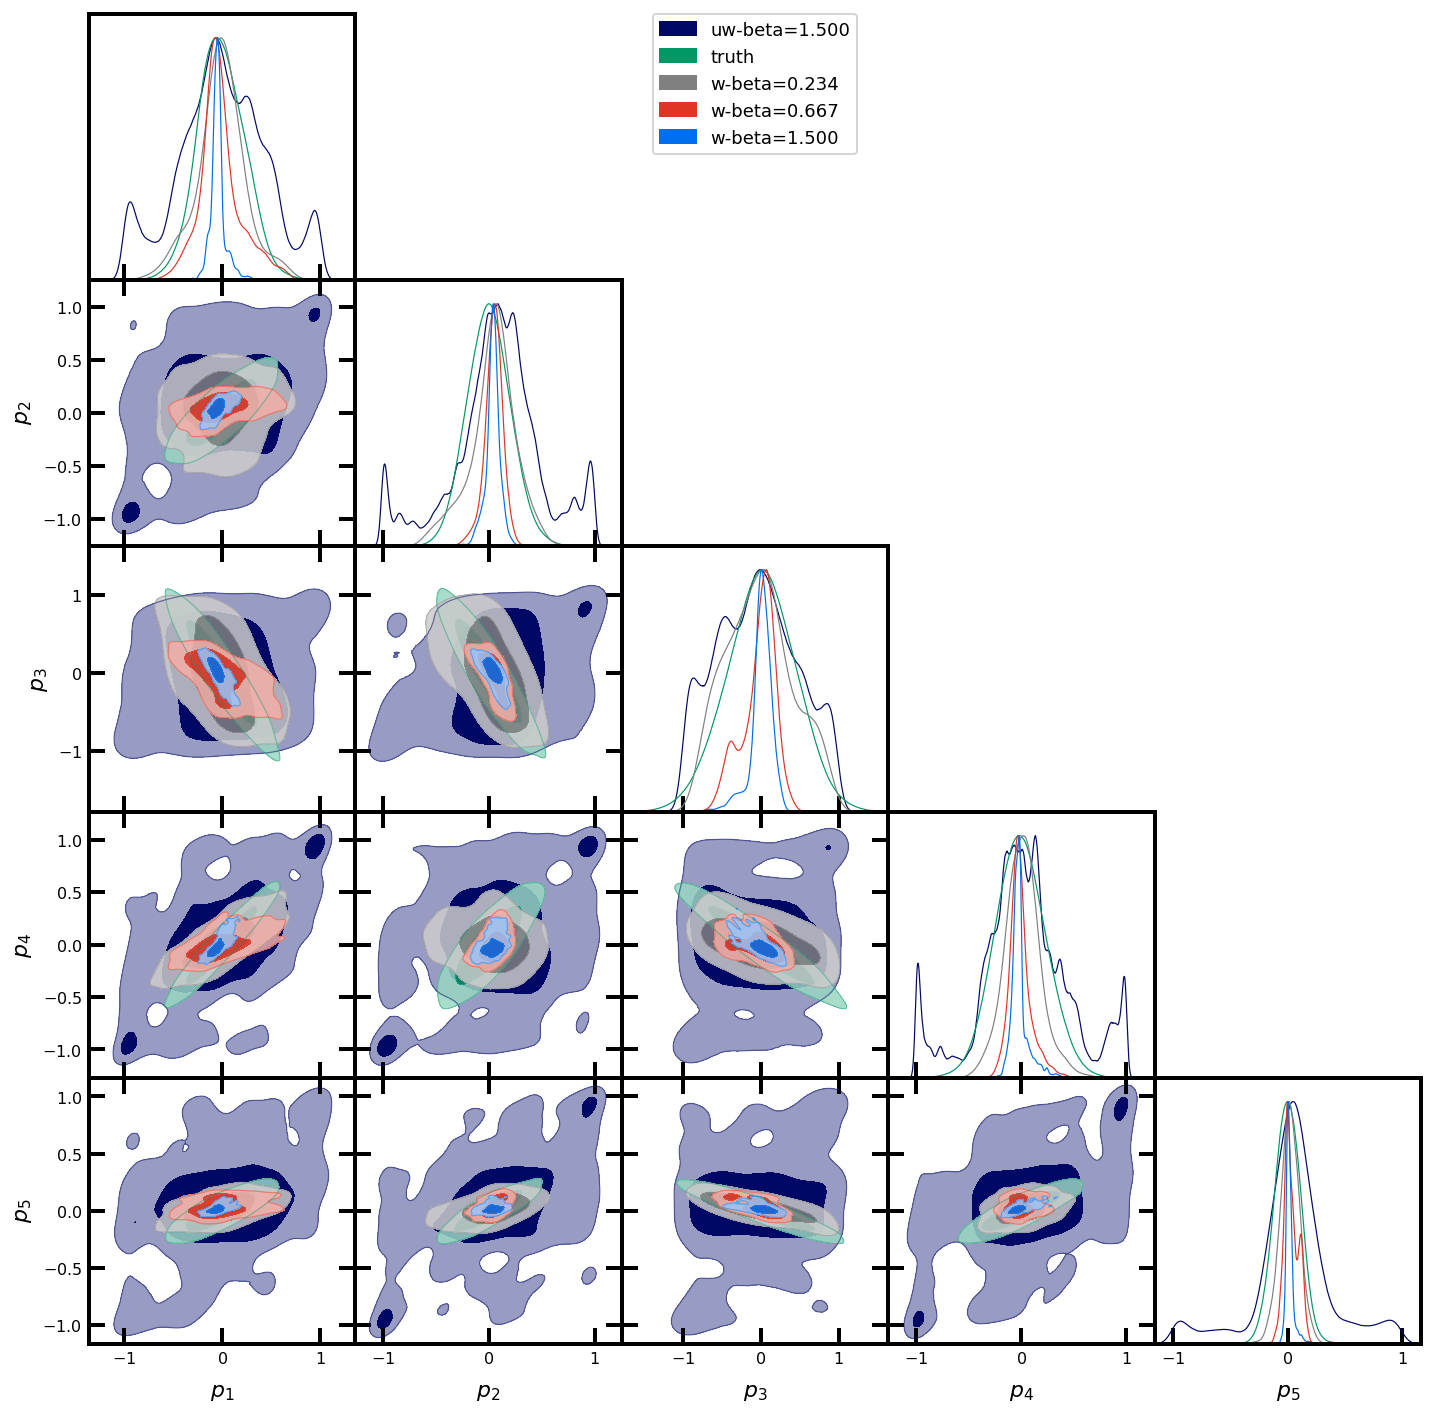

In [52]:
 #hmm I don't have the q_uw samples saved at each step, should add this
qnum = np.unique([int(s.split('q')[1].split('_')[0]) for s in list(cg5['q_models'][0].keys())]).max()

logq_w_test = t2a(cg5['q_models'][0]['q{0}_w'.format(qnum)].evaluate_density(a2t(cg5['q_samples'][0]['q{0}'.format(qnum)])))
logq_uw_test = t2a(cg5['q_models'][0]['q{0}_uw'.format(qnum)].evaluate_density(a2t(cg5['q_samples'][0]['q{0}'.format(qnum)])))
logIW3_beta1p5 = np.array(1.5*cg5['logp'][0]['q{0}'.format(qnum)] - logq_uw_test)
IW3_weighted_samples = (cg5['q_samples'][0]['q{0}'.format(qnum)].T*np.exp(logIW3_beta1p5)).T
#normalize to 1
IW3_weighted_samples_w = (cg5['q_samples'][0]['q{0}'.format(qnum)].T*np.exp(logIW3_beta1p5-logsumexp(logIW3_beta1p5))).T


logIW1 = np.array(1.5*cg5['logp'][0]['q{0}'.format(qnum)]-logq_w_test)
IW1=np.exp(logIW1)
fin_IW1 = IW1!=np.inf

beta_idx=qnum
print(qnum)
beta_idx_2=22
beta_idx_3=18

logq_uw_test = t2a(cg5['q_models'][0]['q{0}_uw'.format(beta_idx)].evaluate_density(a2t(cg5['q_samples'][0]['q{0}'.format(beta_idx)])))

truth = n_mvn.rvs(mean=np.zeros(n),cov=Cov,size=2000)
truth_gd = MCSamples(samples=truth,label='truth')

s_iw3 = IW3_weighted_samples
samples_iw3_b1 = MCSamples(samples=cg5['q_samples'][0]['q{0}'.format(beta_idx)], weights=np.exp(np.array(cg5['logp'][0]['q{0}'.format(beta_idx)] - logq_uw_test)),label='iw3-b1')


samples_uw = MCSamples(samples=t2a(cg5['q_models'][0]['q{0}_uw'.format(beta_idx)].sample(2000,device='cpu')[0]),label='uw-beta={0:.3f}'.format((np.array(cg5['betas'][0])*1.5)[beta_idx]))
samples_w = MCSamples(samples=t2a(cg5['q_models'][0]['q{0}_w'.format(beta_idx)].sample(2000,device='cpu')[0]),label='w-beta={0:.3f}'.format((np.array(cg5['betas'][0])*1.5)[beta_idx]))
samples_w_2 = MCSamples(samples=t2a(cg5['q_models'][0]['q{0}_w'.format(beta_idx_2)].sample(2000,device='cpu')[0]),label='w-beta={0:.3f}'.format((np.array(cg5['betas'][0])*1.5)[beta_idx_2]))
samples_w_3 = MCSamples(samples=t2a(cg5['q_models'][0]['q{0}_w'.format(beta_idx_3)].sample(2000,device='cpu')[0]),label='w-beta={0:.3f}'.format((np.array(cg5['betas'][0])*1.5)[beta_idx_3]))

# thrs=1e-8
g = plots.get_subplot_plotter()
g.triangle_plot([samples_uw,truth_gd,samples_w_3,samples_w_2,samples_w], filled=True)
plt.savefig('../v1qw_compare_beta0p5_beta1p5.png')
plt.show()